In [1]:
import numpy as np
import networkx as nx

In [2]:
# gen_initial_perm: Genera una permutacion inicial
# Dada una matriz de adyacencia A, genera la permutacion de vertices sigma, donde
# sigma es la permutacion donde los nodos estan en orden decreciente segun su grado
def gen_initial_perm(A):
    #grados = np.zeros(A.shape[0])
    grados = np.apply_along_axis(sum, 1, A)
    
    return np.flip(np.argsort(grados)) #argsort retorna los indices que ordenan la lista, justo lo que queremos 

In [3]:
#Se genera un grafo aleatorio para testear el algoritmo

G = nx.fast_gnp_random_graph(50,0.4)
L = nx.adjacency_matrix(G).todense()
s = gen_initial_perm(L)
dict_t = {}
for i in range(s.size):
    dict_t[s[i]] = str(i)

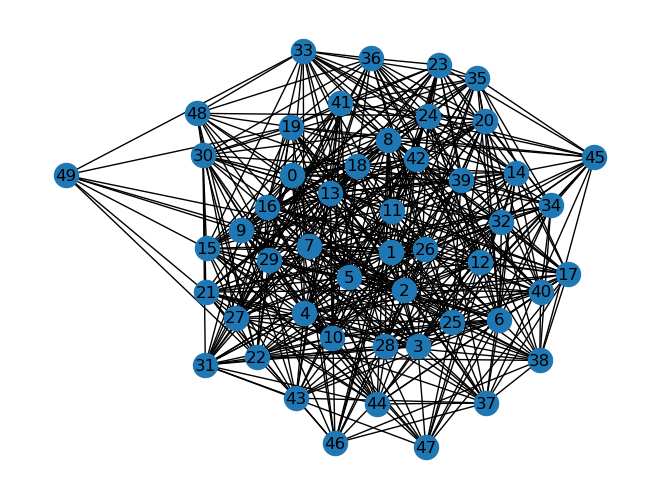

In [4]:
#Se dibujo el grafos
nx.draw(G, labels=dict_t)

In [5]:
# graph_clique : Dibujo el grafo dado y resalta el m-clique dado
# G es el grafo, m es el tamano del clique, sigma es la permutacion de los nodos donde
# sus primeras m entradas son las entradas del clique}
# se advierte que esta funcion solo dibuja, no revisa si efectivamente existe el clique
def graph_clique(G,m,sigma):
    pos = nx.spring_layout(G)
    #print(sigma_lol)
    nodes = {
        'r': sigma[0:m],
        'b': sigma[m:]
    }
    aristas = []
    for i in range(m-1):
        for j in range(i,m):
            aristas.append( (sigma[i],sigma[j]) )

    for node_color, nodelist in nodes.items():
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_color, node_size = 25)

    labels = {x: x for x in G.nodes}
    #nx.draw_networkx_labels(G, pos, labels, font_size='0', font_color='w')
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    nx.draw_networkx_edges(G,pos,
                           edgelist=aristas,
                           width=1.5,alpha=0.8,edge_color='r')

# Primera implementación del SA para m-clique

In [6]:
# F : Funcion objetivo a minimizar
# A es matriz de adyacencia, sigma es una permutacion de los nodos, m es el tamano del clique
def F(A, sigma,m):
    h = 0
    for k in range(m-1):
        for l in range(k+1,m):
            h += 1 - A[sigma[k],sigma[l]]
    return h

# F_prima : Funcion auxiliar usada para encontrar vecino
# A es matriz de adyacencia, z es algun indice de algun nodo, m el tamano del clique
def F_prima(z,A,m):
    l = 0
    for i in range(m):
        if i == z: continue
        
        l += A[i,z]
    
    return l
    
# vecino:
# Dada una permutacion, entregua un vecino el cual se obtiene siguiendo las reglas del paper
# m es el numero del clique que se busca, A es matriz de adyacencia
def vecino(sigma,m,A):
    n = A.shape[0]
    new_sig = sigma.copy()
    
    u = np.random.randint(0,m)
    w = np.random.randint(m,n)
    contador = 0
    
    #Restricting Condition

    while F_prima(u,A,m) > F_prima(w,A,m):
        contador += 1
        if contador >= 8*n: # se acepta de todas formas
            break
            
        w = np.random.randint(m,n)
    
    new_sig[u] = sigma[w]
    new_sig[w] = sigma[u]
    
    return new_sig

In [7]:
#Decision_SA : Resuelve el problema de decision de m-clique con SA
# m es el tamano del clique, steps es la cantidad maxima de pasos que SA realiza
# A es la matriz de adyacencia del grafo, beta funcion de temperatura
def Decision_SA(m,steps,A,beta):
    sigma = gen_initial_perm(A)
    cost = F(A,sigma,m)
    
    for n in range(steps):
        
        u = np.random.uniform(0, 1)
        sigma_new = vecino(sigma,m,A)
        cost_new =  F(A,sigma_new,m)
        
        if cost_new == 0:
            sigma = sigma_new
            break
        else:
            cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))
            
            if u <= cte:
                sigma = sigma_new
                cost = cost_new
                
    return (sigma_new, n)

## Probando el algoritmo

In [8]:
def beta_lol(n):
    return np.exp(n/1000)

sigma_lol, n_lol = Decision_SA(6,1000000,L,beta_lol)
print(n_lol)

985


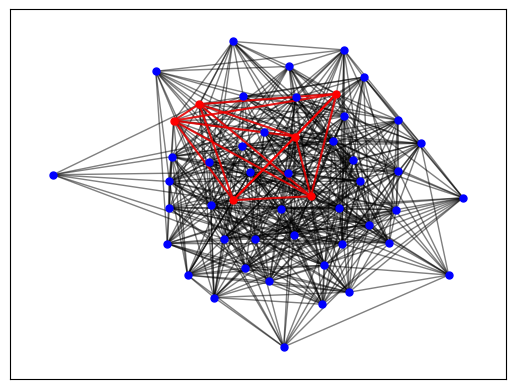

In [9]:
graph_clique(G,6,sigma_lol)

In [10]:
#Clique encontrado por SA
print(sigma_lol[0:6])

[11  2 49 17 40 31]


In [11]:
#Clique aproximado por el algoritmo de aproximacion 
nx.approximation.max_clique(G)

{0, 1, 16, 29, 46}

In [12]:
#Clique encontrado por el algoritmo exacto
for node in G.nodes():
    G.nodes[node]['weight'] = 1

nx.algorithms.max_weight_clique(G)

([14, 7, 45, 26, 39, 1], 6)

## Leyendo grafos de DIMAC 

In [13]:
# read_DIMAC: recibe como input la direccion de un archivo de un grafo dimac en formato ascii
# y entrega un grafo de NetworkX que corresponde al grafo del archivo
def read_DIMAC(archivo):
    edges_d = []

    with open(archivo) as f:
        lines = f.readlines()

    for line in lines:
        if line[0] != 'e':
            continue

        edges_tmp = line[2:].strip().split() 
        for i in range(2):
            edges_tmp[i] =  int(edges_tmp[i]) - 1
        
        edges_d.append(edges_tmp )

    g = nx.Graph()
    g.add_edges_from(edges_d)

    return g

In [14]:
#Leyendo C125.9
H = read_DIMAC("dimacs_graphs/C125.9.clq")

for node in H.nodes():
    H.nodes[node]['weight'] = 1

In [15]:
sigma_lol, n_lol = Decision_SA(34,100000,nx.adjacency_matrix(H).todense(),beta_lol)
print(n_lol)

6091


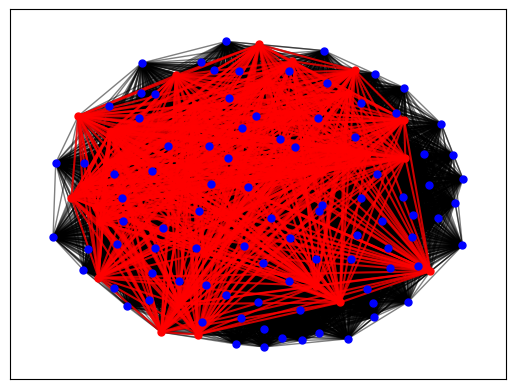

In [16]:
graph_clique(H,34,sigma_lol)

In [17]:
nx.algorithms.max_weight_clique(H)

([82,
  67,
  92,
  70,
  121,
  120,
  116,
  78,
  43,
  114,
  30,
  4,
  0,
  47,
  24,
  8,
  1,
  122,
  76,
  33,
  69,
  17,
  48,
  84,
  28,
  10,
  109,
  100,
  81,
  79,
  6,
  113,
  59,
  53],
 34)

## Generando estadisticas

In [18]:
# get_estadisticas_decision : 
# Dado un grafo, ejecuta el SA, retornando un vector del numero de pasos que se demoro en terminar
# si es que termino de manera exitosa
def get_estadisticas_decision(A,m,max_step,beta,times):
    contador = 0
    v = np.zeros(times)
    while contador < times:
        sigma, n = Decision_SA(m,max_step,A,beta)
        if n == max_step-1:
            continue
        
        v[contador] = n
        
        contador += 1
    return v

In [19]:
# Definiendo temperaturas exponenciales y cuadraticas para comparar
beta_1 = lambda x : (x/10000)**2
beta_2 = lambda x : np.exp(x/10000)

In [20]:
lol = get_estadisticas_decision(L,5,int(1e5),beta_1,100)
print(lol.mean())
print(lol.std())
lol = get_estadisticas_decision(L,5,int(1e5),beta_2,100)
print(lol.mean())
print(lol.std())

4298.84
2916.4759204217685
643.72
640.0015168732025


# Primera implementación del SA para MaxClique

La idea es ejecutar el SA anterior, esta vez en un grafo de configuraciones gigante que consiste en la unión de todos los grafos de configuraciones considerados anteriormente, donde cada configuración sera una tupla de la forma $(\sigma,k)$, donde $\sigma$ es la permutación en juego y $k$ es el clique que se esta investigando en el momento del algoritmo, los vecinos de $(\sigma,k)$ son las tuplas de la forma $(\sigma,k+1),(\sigma,k-1),(\tau,k)$ donde $\tau$ es una configuración vecina de $\sigma$ en el grafo del SA original, se subentiende que la ultima etiqueta se toma modulo $n$, ie $0 = n$ donde $n$ es el número de nodos.

Este grafo sigue siendo regular ya que cada nodo tiene los vecinos que tenia en el grafo anterior más dos vecinos adicionales, por ende la regularidad se mantiene.

La función a optimizar en este caso es $H$, la cual es la suma de dos funciones $F_k$ y $p$ de acuerdo al siguente esquema

$$H(\sigma,k) = F_k(\sigma) + p(k)$$

Donde $F_k(\sigma)$ es la función que se minimizaba anteriormente para el problema de decisión de k-clique, y $p$ es una función de penalización que idealmente es inversamente proporcional al $k$, ie, los $k$ más cercano a $1$ (cliques más pequeños) tienen mayor peso.

In [21]:
# vecino_2 : Elige un vecino dado un sigma y un tamano de clique m
# el vecino puede ser una permutacion vecina con el mismo numero de clique
# o la misma permutacion con el numero de clique cambiado
def vecino_2(sigma,m,A):
    n = A.shape[0]
    new_sig = sigma.copy()
    
    s = np.random.binomial(1, 1/(m*(n-m) + 1) )  #Realmente hay que considerar si este p que estamos tomando es 
                                                 # demasiado pequeno, si es asi, se deben considerar otras formas
    u = np.random.randint(0,m)
    w = np.random.randint(m,n)
    contador = 0
    
    #Caso en que se elige un clique mayor y  no se cambia la permutacon considerada
    
    if s == 1: #Se cambia de clique
        w = np.random.binomial(1, 0.5) #Se tira una moneda balanceada para elegir si se baja o sube
        if w == 2:
            if m == n-1:
                return sigma, 1
            else:
                return sigma, m+1
        else:
            if m == 3:
                return sigma, n-1
            else:
                return sigma, m-1
    
    #Caso en que se cambia la permutacion considerada pero no se cambia el clique
    
    while F_prima(u,A,m) > F_prima(w,A,m):
        contador += 1
        if contador >= 8*n: # se acepta de todas formas
            break
            
        w = np.random.randint(m,n)
    
    new_sig[u] = sigma[w]
    new_sig[w] = sigma[u]
    
    return new_sig, m

#MaxClique_SA
def MaxClique_SA(steps,A,m_inicial,beta, penalizacion,sensibilidad):
    #Inicializacion
    m = m_inicial
    sigma = gen_initial_perm(A)
    cost_clique = F(A,sigma,m)
    cost = sensibilidad*cost_clique + penalizacion(m)
    
    #Se comienza a iterar
    for n in range(steps):
        
        u = np.random.uniform(0, 1)
        
        #Se elige vecino
        sigma_new , m = vecino_2(sigma,m,A)
        
        #Se recuerda que si esto es costo 0, entonces tiene un clique de tamano m
        cost_clique =  F(A,sigma_new,m)
        cost_new = sensibilidad*cost_clique + penalizacion(m)
        
        if cost_clique == 0:
            print("Se ha encontrado clique de tamaño ", m)
            print(sigma_new[:m])

        cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))
            
        if u <= cte:
            sigma = sigma_new
            cost = cost_new
                
    return sigma_new, n

In [50]:
#Se elige una funcion de penalizacion
def p_1(k):
    return 1/(k**3)

In [59]:
sigma_lol, n_lol = MaxClique_SA(100000,L,4,beta_lol,p_1,1)
print(n_lol)


Se ha encontrado clique de tamaño  4
[23  7 38 39]
Se ha encontrado clique de tamaño  4
[39  7 38 43]
Se ha encontrado clique de tamaño  4
[ 0 25 46 27]
Se ha encontrado clique de tamaño  4
[19 25 46 24]
Se ha encontrado clique de tamaño  3
[ 3 38  4]
Se ha encontrado clique de tamaño  3
[30 38  4]
Se ha encontrado clique de tamaño  3
[30 38  0]
Se ha encontrado clique de tamaño  3
[30 37  0]
Se ha encontrado clique de tamaño  3
[21 36 10]
Se ha encontrado clique de tamaño  3
[13 46 21]
Se ha encontrado clique de tamaño  3
[29 23 46]
Se ha encontrado clique de tamaño  3
[29 23  6]
Se ha encontrado clique de tamaño  3
[ 9  5 45]
Se ha encontrado clique de tamaño  3
[36 30  4]
Se ha encontrado clique de tamaño  3
[36 14 18]
Se ha encontrado clique de tamaño  3
[32  7 14]
Se ha encontrado clique de tamaño  3
[43  9 38]


/tmp/ipykernel_5994/541393968.py:67: RuntimeWarning: overflow encountered in exp
  cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))


Se ha encontrado clique de tamaño  4
[36  9 49 10]
Se ha encontrado clique de tamaño  4
[36  9 49 22]
Se ha encontrado clique de tamaño  4
[36 21 49 22]
Se ha encontrado clique de tamaño  4
[36 21 24 22]
Se ha encontrado clique de tamaño  4
[36 21 24 18]
Se ha encontrado clique de tamaño  4
[36 21 24  2]
Se ha encontrado clique de tamaño  4
[36 21 24 18]
Se ha encontrado clique de tamaño  4
[36 21 10 18]
Se ha encontrado clique de tamaño  4
[35 21 10 18]
Se ha encontrado clique de tamaño  4
[36 21 10 18]
Se ha encontrado clique de tamaño  4
[36 21 49 18]
Se ha encontrado clique de tamaño  4
[36 21 49 10]
Se ha encontrado clique de tamaño  4
[36 21 18 10]
Se ha encontrado clique de tamaño  4
[36 21  4 10]
Se ha encontrado clique de tamaño  4
[36 21 49 10]
Se ha encontrado clique de tamaño  4
[36 21  4 10]
Se ha encontrado clique de tamaño  4
[36 21  4 18]
Se ha encontrado clique de tamaño  4
[10 21  4 18]
Se ha encontrado clique de tamaño  4
[10 36  4 18]
Se ha encontrado clique de tama

99999
